In [32]:
#When running this from .py , import sys and call for conda activate /anaconda3/envs/scrapy

In [75]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split


In [39]:
df_met = pd.read_csv('metallica.csv', index_col = 0)
df_met['Artist'] = 'metallica'
df_met.rename(columns={'metallica':'Lyrics'}, inplace=True)
df_pj = pd.read_csv('pearl-jam.csv', index_col = 0)
df_pj['Artist'] = 'pearl-jam'
df_pj.rename(columns={'pearl-jam':'Lyrics'}, inplace=True)
df_queen = pd.read_csv('queen.csv', index_col = 0)
df_queen['Artist'] = 'queen'
df_queen.rename(columns={'queen':'Lyrics'}, inplace=True)

## Match the numbers of rows for every artists - set the others aside for test data ##

### Concatenate the dataframes for individual artists ###

In [40]:
df_lyrics = pd.concat([df_met,df_pj,df_queen], axis = 0, ignore_index=True)

In [41]:
df_lyrics.shape

(677, 3)

In [42]:
df_lyrics.isna().sum()

Song_name     0
Lyrics       47
Artist        0
dtype: int64

In [43]:
df_lyrics = df_lyrics.dropna(axis = 0)

In [44]:
df_lyrics.shape

(630, 3)

In [45]:
df_lyrics['Lyrics'].value_counts()

"Unfortunately, we are not authorized to show these lyrics"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

### Drop unnecessary junk stuff ###

In [46]:
#df_lyrics = df_lyrics[~df_lyrics['Lyrics'].isin()]
df_lyrics = df_lyrics[~df_lyrics.Lyrics.str.contains("Unfortunately, we are not authorized to show these lyrics")]
df_lyrics = df_lyrics[~df_lyrics.Lyrics.str.contains("(instrumental)")]
df_lyrics = df_lyrics[~df_lyrics.Lyrics.str.contains("Instrumental")]
#df_lyrics['Lyrics'] = df_lyrics['Lyrics'].replace(r'\W+|LYRICS|lyrics',' ', regex=True)


/anaconda3/envs/scrapy/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [47]:
df_lyrics.shape

(612, 3)

In [49]:
df_lyrics['Lyrics'] = df_lyrics['Lyrics'].replace(r'\W+|LYRICS|lyrics',' ', regex=True)

In [56]:
df_lyrics

,Song_name,Lyrics,Artist
0,the shortest straw,Suspicion is your name Your honesty to blame ...,metallica
1,all within my hands,All within my hands All within my hands Squee...,metallica
2,low mans lyric,My eyes seek reality My fingers seek my veins...,metallica
3,sabbra cadabra,Feel so good I feel so fine Love that little ...,metallica
4,just a bullet away,All roads they lead to shame All drowning in ...,metallica
...,...,...,...
672,follin around,You re so beautiful you just lay it on me Fox...,queen
673,who needs you,I make it half past six you come at seven Alw...,queen
674,rain must fall,I can see it in your stars Life is so excitin...,queen
675,fight from the inside,Words and music by roger taylor Hey you boy h...,queen


In [52]:
df_lyrics.groupby('Artist').count()

,Song_name,Lyrics
Artist,,
metallica,157,157
pearl-jam,228,228
queen,227,227


In [62]:
#metallica = df_lyrics(df_lyrics['Artist']=='metallica')
metallica = df_lyrics.loc[df_lyrics['Artist'] == 'metallica']
pearljam = df_lyrics.loc[df_lyrics['Artist'] == 'pearl-jam']
queen = df_lyrics.loc[df_lyrics['Artist'] == 'queen']

In [69]:
#Equalize the numbers or do class balancing

pearljam = pearljam.head(175)
queen = queen.head(175)

In [71]:
#Create a new dataframe for train_test split
df_lyrics_1 = pd.concat([metallica,pearljam,queen], axis = 0, ignore_index=True)

In [74]:
#Map numbers as artist for y data
df_lyrics_1['ydata'] = df_lyrics_1['Artist'].map({'metallica': 0, 'pearl-jam': 1, 'queen': 2})
df_lyrics_1.head()

,Song_name,Lyrics,Artist,ydata
0,the shortest straw,Suspicion is your name Your honesty to blame ...,metallica,0
1,all within my hands,All within my hands All within my hands Squee...,metallica,0
2,low mans lyric,My eyes seek reality My fingers seek my veins...,metallica,0
3,sabbra cadabra,Feel so good I feel so fine Love that little ...,metallica,0
4,just a bullet away,All roads they lead to shame All drowning in ...,metallica,0


In [79]:
model = spacy.load('en_core_web_md')

In [80]:
def lemm(x):
    clean = []
    tokens = model(x)
    for token in tokens:
        if not token.is_stop:
            clean.append(token.lemma_)
    return " ".join(clean)
            

In [127]:
#def W2v(x):
#    clean = []
#    lemm = lemm(x)
#    tokens = model(lemm)
#    for token in tokens:
#        clean.append(model.vocab[f'{token}'].vector)
#    return clean
#model.vocab['coffee'].vector # Every lemmatized token will be a vector


In [84]:
df_lyrics_1['Token'] = df_lyrics_1['Lyrics'].apply(lemm)

In [86]:
df_lyrics_1.head()

,Song_name,Lyrics,Artist,ydata,Token
0,the shortest straw,Suspicion is your name Your honesty to blame ...,metallica,0,suspicion honesty blame dignity shame Dishon...
1,all within my hands,All within my hands All within my hands Squee...,metallica,0,hand hand squeeze crush hand hold dear hold ...
2,low mans lyric,My eyes seek reality My fingers seek my veins...,metallica,0,eye seek reality finger seek vein s dog step...
3,sabbra cadabra,Feel so good I feel so fine Love that little ...,metallica,0,feel good feel fine love little lady mind gi...
4,just a bullet away,All roads they lead to shame All drowning in ...,metallica,0,road lead shame drowning blame reflection lo...


In [87]:
tv = TfidfVectorizer()

In [88]:
ex = tv.fit_transform(df_lyrics['Token'])

In [89]:
ex

<507x4715 sparse matrix of type '<class 'numpy.float64'>'
	with 24810 stored elements in Compressed Sparse Row format>

In [90]:
df_2 = pd.DataFrame(ex.todense(), columns = tv.get_feature_names()) # dense because we save zeros

In [92]:
final_df = pd.concat([df_2, df_lyrics_1], axis = 1)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(final_df.loc[:,'000':'zu'], final_df['ydata'], test_size=0.20, random_state=42)

In [99]:
test = pd.concat([X_test, y_test], axis = 1)

In [101]:
test.to_csv('Song_Test.csv')

In [102]:
train_data = pd.concat([X_train, y_train], axis = 1)

,000,12th,17x,1880,1995,1st,2010,22,24,2nd,...,youth,yup,zap,zarkhov,zero,zone,zoo,zoom,zu,ydata
444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Implement Naive Bayes ##

In [1]:
# X data is simply the TFIDF matrix
#We need y data
#Convert the artist names to numbers

In [104]:
from sklearn.naive_bayes import MultinomialNB

In [238]:
m = MultinomialNB(alpha = 0.001)

In [239]:
m.fit(train_data.loc[:, '000':'zu'], train_data['ydata'])

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [267]:
yped = m.predict(train_data.loc[:, '000':'zu'])

1.0

In [315]:
new_song = ['I am a man who is strong']

In [316]:
#Make a TV transform of the new song
tv_vec = tv.transform(new_song)

In [317]:
new_song_df = pd.DataFrame(tv_vec.todense(), columns=tv.get_feature_names())

In [318]:
new_song_df

,000,12th,17x,1880,1995,1st,2010,22,24,2nd,...,young,youth,yup,zap,zarkhov,zero,zone,zoo,zoom,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [320]:
m.predict(tv_vec)

array([0])

In [321]:
m.predict_proba(tv_vec)

array([[0.44264037, 0.26197672, 0.29538291]])

In [322]:
#{'metallica': 0, 'pearl-jam': 1, 'queen': 2}

In [323]:
m.score(tv_vec, [0])

1.0

In [324]:
!pip install wordcloud

     |████████████████████████████████| 157 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 8.6 MB/s eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
     |████████████████████████████████| 67 kB 12.5 MB/s eta 0:00:01
  Using cached kiwisolver-1.1.0-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (113 kB)


In [350]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 


In [351]:
#stopwords_in = ['yeah', 're', 'll']
metallica_cloud = ' '
for word in df_lyrics_1['Token'].loc[df_lyrics_1['Artist'] == 'metallica']:
    metallica_cloud = metallica_cloud + word + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', stopwords = stopwords_in, 
                min_font_size = 10).generate(metallica_cloud)

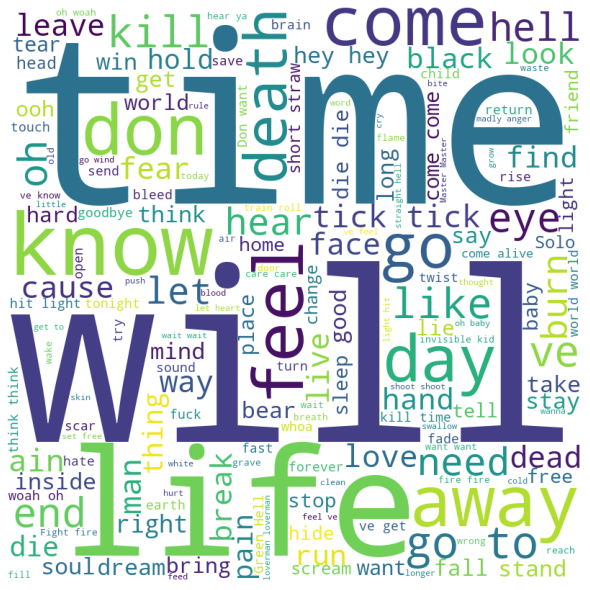

In [353]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.savefig('metallica.png')
plt.show() 


In [354]:
stopwords_pj = ['don']
pj_cloud = ' '
for word in df_lyrics_1['Token'].loc[df_lyrics_1['Artist'] == 'pearl-jam']:
    pj_cloud = pj_cloud + word + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', stopwords = stopwords_pj, 
                min_font_size = 10).generate(pj_cloud)

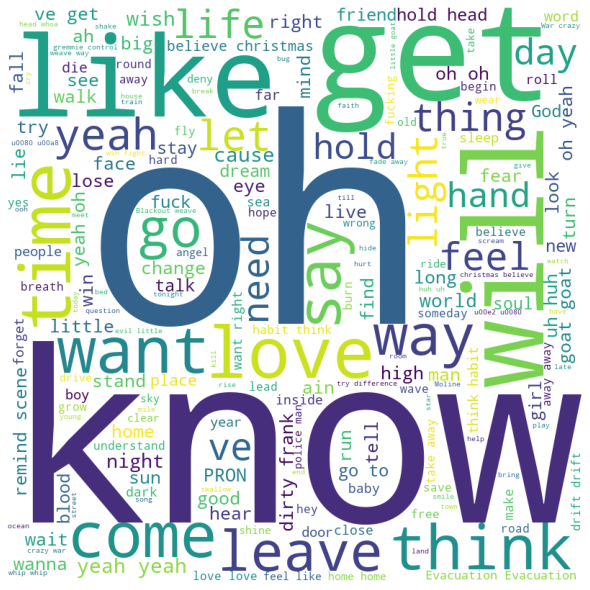

In [355]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('pearljam.png')  
plt.show() 

In [356]:
stopwords_pj = ['don']
queen_cloud = ' '
for word in df_lyrics_1['Token'].loc[df_lyrics_1['Artist'] == 'queen']:
    queen_cloud = queen_cloud + word + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', stopwords = stopwords_pj,
                min_font_size = 10).generate(queen_cloud)

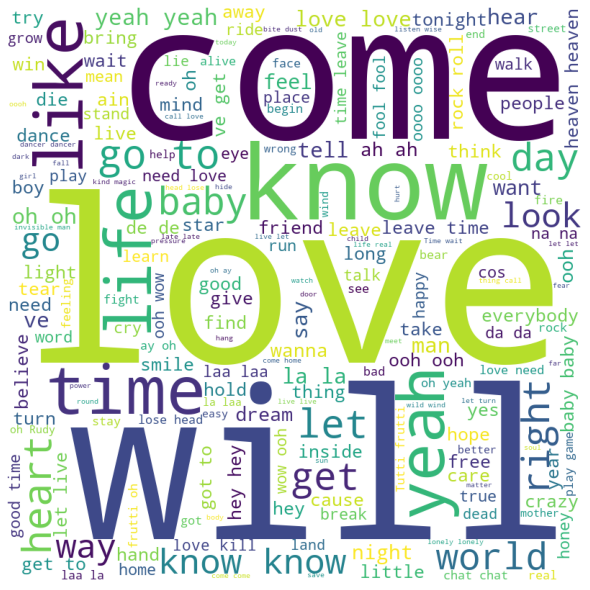

In [357]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('queen.png')  
plt.show() 